In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
import torch.nn.functional as f

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

np.random.seed(3)

### $N$-dimensional features, scalar regression target, with covariance

### Problem

We consider a egression problem with N-dimensional features $x$, scalar targets $t$ and known variance $\sigma^2$ We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic N-dimensional basis function $\phi$, le likelihood is expressed as:

\begin{align}
p(t | a, b, x, \sigma) & = \mathcal{N}(a \phi(x) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(a) = \mathcal{N}(0,1) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

It is then possible to compute the posterior of parameters analytically, given $(\mathbf{x}, \mathbf{t})$ the entire dataset:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}, \sigma^2) = \frac{p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2) p(a,b)}{p(\mathbf{t}, \mathbf{x})}
\end{align}

$p(\mathbf{t})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

We propose to optimize $\theta$ using maximum likelihood and $a, b$ using Variational Inference, which allows us deriving a lower bound of the marginal log likelihood (with regards to $a,b$) that we can optimize end-to-end. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x}, \sigma^2, \theta) & = \log \int_{a,b} \log p(\mathbf{t}, a, b, | \mathbf{x}, \sigma^2, \theta) dadb \\
& = \log \int_{a,b} \log p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta)p(a,b) dadb \\
& = \log \int_{a,b} q(a,b) p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} dadb \\
& \geq \mathbb{E}_{q(a,b)} \left[ \log  p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} \right] \\
& = \mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] - \mathrm{KL}(q(a,b) \ ||\ p(a,b)) \\
= \mathcal{L_(t, x)}
\end{align}

#### Modelling the posterior of vector quantities with covariance

In this context, $a$ is a vector of size $N$ and $b$ a scalar. We write $v$ the vector representing all the parameters ${a_i}_a + b$. In this context, we choose to model the approximate posterior of $v$ using a **Multivariate Gaussian** parametrized by a Cholesky factor $L$, which allows us to apply the reparametrization trick [[Pathwise Derivatives Beyond the Reparameterization Trick]](https://arxiv.org/pdf/1806.01851.pdf):

\begin{align}
y \sim \mathcal{N}(\mu, L) \\
y = \mu + L \epsilon \\
\epsilon \sim \mathcal{N}(\mu, I)
\end{align}

The covariance matrix is then defined as:

\begin{aligned} \boldsymbol{\Sigma} &=\mathbb{E}\left[(\mathbf{z}-\mathbb{E}[\mathbf{z} |])(\mathbf{z}-\mathbb{E}[\mathbf{z} |])^{T}\right] \\ &=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ &=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ &=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ &=\mathbf{L} \mathbf{L}^{T} \end{aligned}


We can then write our ELBO as:

\begin{split}
\mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] =  \mathbb{E}_q \left[ \sum_{x \in \mathbf{x}} \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t - a f_{\theta}(x) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(v) \ ||\ p(v)) = -\frac{1}{2} \sum_{i\in v} \left(1 + \log L_{i,i}^2 - \mu_i^2 - L_{i,i}^2\right)
\end{split}

**TODO: check if KL correct**


### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Berkley Kingma ppt](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

### Toy Dataset

Take $N$ random points in $[-1, 1]$, compute some function of the points and add noise, finally divide the data in $K=3$ classes of equal size.

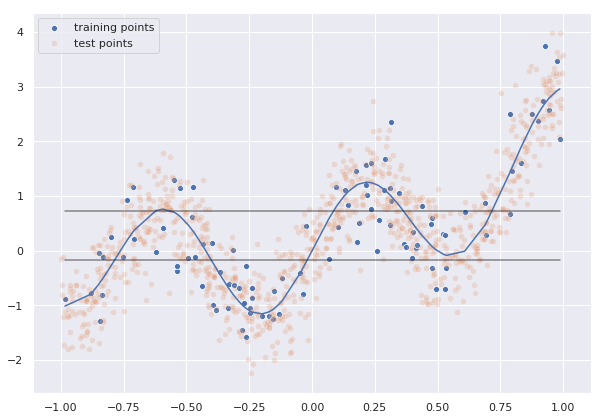

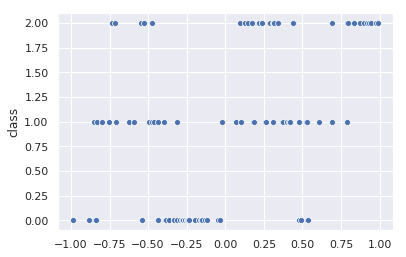

x shape: (100, 1)
x test shape: (1000, 1)
t shape: (100, 3)
t_values shape: (100,)


In [2]:
N = 100    # data points
N_test = 1000  # test data points
sigma = .5   # final noise
n_classes = 3

x = np.random.rand(N + N_test, 1) * 2 - 1

fx = x**2 + x + np.sin(8 * x)
noisy_fx = fx + sigma*np.random.randn(*x.shape)  # function to compute labels

# Divide data interval in n_classes regions
# thresholds = np.linspace(tmp.min() - 1e-3, tmp.max() + 1e-3, n_classes+1)  # equal size
thresholds = np.percentile(noisy_fx, np.linspace(0, 100, n_classes+1))  # balanced classes

# targets
t = np.zeros((noisy_fx.shape[0], n_classes), dtype=int)  # one-hot, shape (N, C)
for i in range(n_classes):
    t[:, i] = ((thresholds[i] < noisy_fx) * (thresholds[i+1] >= noisy_fx))[:, 0]
t_values = t * np.arange(n_classes).reshape((1, -1))
t_values = np.sum(t_values, 1)

x_test = x[:N_test]
x = x[N_test:]
fx_test = fx[:N_test]
fx = fx[N_test:]
noisy_fx_test = noisy_fx[:N_test]
noisy_fx = noisy_fx[N_test:]
t_test = t[:N_test]
t = t[N_test:]
t_values_test = t_values[:N_test]
t_values = t_values[N_test:]

test_sort_idx = np.argsort(x_test, axis=0).flatten()
x_test, fx_test, noisy_fx_test, t_test, t_values_test = (
    tensor[test_sort_idx] for tensor in [x_test, fx_test, noisy_fx_test, t_test, t_values_test])
sort_idx = np.argsort(x, axis=0).flatten()
x, fx, noisy_fx, t, t_values = (tensor[sort_idx] for tensor in [x, fx, noisy_fx, t, t_values])


# Plot continuous data and class thresholds
plt.figure(figsize=(10, 7))
plt.plot(x, fx)
sns.scatterplot(x[:, 0], noisy_fx[:, 0], label='training points')
sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0], alpha=0.2, label='test points')
for i in range(1, n_classes):
    plt.plot([x[0], x[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
plt.legend()
plt.show()

# Plot class distribution
sns.scatterplot(x[:, 0], t_values)
plt.ylabel('class')
plt.show()


# # Plot continuous data and class thresholds: test data
# plt.figure(figsize=(10, 7))
# plt.plot(x_test, fx_test)
# sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0])
# for i in range(1, n_classes):
#     plt.plot([x_test[0], x_test[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
# plt.show()



print('x shape:', x.shape)
print('x test shape:', x_test.shape)

print('t shape:', t.shape)
print('t_values shape:', t_values.shape)

x = torch.tensor(x, dtype=torch.float)
t_values = torch.tensor(t_values, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float)
t_values_test = torch.tensor(t_values_test, dtype=torch.long)

#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $\mathbf{h} = f_{\theta}(x)$, with parameters $\theta$ to be optimized. The features $\mathbf{h}$ have size $m$, the weight matrix $\mathbf{a}$ has shape $m \times k$, the bias $\mathbf{b}$ has size $k$, and $k$ is the number of classes. Logits are $\mathbf{h \cdot a} + \mathbf{b}$, with $\mathbf{a}$ and $\mathbf{b}$ multivariate Normal rvs with full covariance (including correlation between $\mathbf{a}$ and $\mathbf{b}$).

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \Sigma)$, and to compute the KL divergence from a prior $\mathcal{N}(0, I)$ to a variational distribution $q = \mathcal{N}(\mu, \Sigma)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out, use_dropout=False):
        super().__init__()
        if use_dropout:
            self.layers = nn.Sequential(
                nn.Linear(1, 64), nn.LeakyReLU(),
                nn.Dropout(0.5),
                nn.Linear(64, 32), nn.LeakyReLU(),
                nn.Dropout(0.25),
                nn.Linear(32, n_out))
        else:
            self.layers = nn.Sequential(
                nn.Linear(1, 64), nn.LeakyReLU(),
                nn.Linear(64, 32), nn.LeakyReLU(),
                nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        """KL from standard normal. Shape is irrelevant, KL is summed over all dimensions."""
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise std $\sigma$.

First train model with ML (no sampling, just train means), then compare with the Bayesian one.

In [4]:
last_layer_size = 16
a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
a_size = np.prod(a_shape)
b_size = n_classes

ml_features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
l_rate = 0.001
epochs = 10000
n_samples = 1  # MC samples per example
n_samples_test = 100
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

optimiser = torch.optim.Adam(list(ml_features.parameters()) + [mu_ab], lr = l_rate, weight_decay=2e-1)

print("*** ML model\n")
for epoch in range(1, epochs + 1):
    ml_features.train()
    optimiser.zero_grad()
    h = ml_features(x)
    recons = torch.zeros((n_samples), device=x.device)
    acc = 0.0
    for i in range(n_samples):
        # Mean from q(a) q(b)
        ab_sample = mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
    acc = acc/n_samples
    
    recons = recons.mean()
    
    loss = recons
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0:
        print(f'epoch {epoch} : loss {loss.item():.3g}   Recons '
              f'{recons.item():.3g}  acc {acc:.3f}')
        
        
    if epoch % 500 == 0:
        with torch.no_grad():
            ml_features.eval()
            h = ml_features(x_test)
            recons = torch.zeros((n_samples_test), device=x.device)
            acc = 0.0
            for i in range(n_samples_test):
                # Mean from q(a) q(b)
                ab_sample = mu_ab
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                # (estimate of -log p(t | x, a, b) for test set, rescaled by N/N_test)
                # TODO should we rescale it actually?
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

            acc = acc/n_samples_test

            recons = recons.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)
            # log E[p(t | x, a, b)] is approximately:
            # log 1/S sum(exp(log(p(t | x, a, b))))
            # = - log S + log(sum(exp(-cross_entropy)))

            loss = recons
            print(f'\nTEST : loss {loss.item():.3g}  Recons '
                  f'{recons.item():.3g}    acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')

# Save parameters
ml_mu_ab = mu_ab

*** ML model

epoch 250 : loss 87   Recons 87  acc 0.550
epoch 500 : loss 76.3   Recons 76.3  acc 0.660

TEST : loss 80.5  Recons 80.5    acc 0.603   ll -85.1

epoch 750 : loss 70.6   Recons 70.6  acc 0.710
epoch 1000 : loss 67.4   Recons 67.4  acc 0.650

TEST : loss 72.2  Recons 72.2    acc 0.683   ll -76.8

epoch 1250 : loss 65.2   Recons 65.2  acc 0.720
epoch 1500 : loss 74.2   Recons 74.2  acc 0.630

TEST : loss 70  Recons 70    acc 0.682   ll -74.6

epoch 1750 : loss 69.4   Recons 69.4  acc 0.660
epoch 2000 : loss 70.6   Recons 70.6  acc 0.650

TEST : loss 67.8  Recons 67.8    acc 0.693   ll -72.4

epoch 2250 : loss 65.3   Recons 65.3  acc 0.730
epoch 2500 : loss 62.4   Recons 62.4  acc 0.690

TEST : loss 70  Recons 70    acc 0.679   ll -74.6

epoch 2750 : loss 62.4   Recons 62.4  acc 0.720
epoch 3000 : loss 64.1   Recons 64.1  acc 0.710

TEST : loss 68.7  Recons 68.7    acc 0.696   ll -73.3

epoch 3250 : loss 65.6   Recons 65.6  acc 0.720
epoch 3500 : loss 66.7   Recons 66.7  acc

In [5]:
last_layer_size = 16
a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
a_size = np.prod(a_shape)
b_size = n_classes

features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
stochastic = CovarianceStochasticLayer()
l_rate = 0.001
epochs = 10000
n_samples = 5  # MC samples per example
n_samples_test = 50
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters)))

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_())

optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, cov_ab_params], lr = l_rate)

print("*** Bayesian model\n")
for epoch in range(1, epochs + 1):
    features.train()
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    elbo = torch.zeros((n_samples), device=x.device)
    recons = torch.zeros_like(elbo)
    kl = torch.zeros_like(elbo)
    acc = 0.0
    for i in range(n_samples):
        # Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
        # KL loss, both analytic and by MC
        #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
        kl[i] = stochastic.get_kl(mu_ab, logvar_ab)
        #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()
    
        elbo[i] = - recons[i] - kl[i]
        
    acc = acc/n_samples
    
    # IW averaging
    elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0:
        print(f'epoch {epoch} : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
              f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}')
        
        
    if epoch % 1000 == 0:
        with torch.no_grad():
            features.eval()
            h = features(x_test)
            cov_ab = flat_to_triangular(cov_ab_params)
            elbo = torch.zeros((n_samples_test), device=x.device)
            recons = torch.zeros_like(elbo)
            kl = torch.zeros_like(elbo)
            acc = 0.0
            for i in range(n_samples_test):
                # Sample once from q(a) q(b)
                ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                # (estimate of -log p(t | x, a, b) for test set, rescaled by N/N_test)
                # TODO should we rescale it actually?
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

                # KL loss, both analytic and by MC
                #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
                kl[i] = stochastic.get_kl(mu_ab, logvar_ab)
                #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()

                elbo[i] = - recons[i] - kl[i]

            acc = acc/n_samples_test

            # IW averaging
            elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)
            # log E[p(t | x, a, b)] is approximately:
            # log 1/S sum(exp(log(p(t | x, a, b))))
            # = - log S + log(sum(exp(-cross_entropy)))

            loss = - elbo
            print(f'\nTEST : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
                  f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')
    

*** Bayesian model

epoch 250 : loss 450 ELBO -450  Recons 450  KL 0.077   acc 0.326
epoch 500 : loss 374 ELBO -374  Recons 374  KL 0.229   acc 0.316
epoch 750 : loss 320 ELBO -320  Recons 320  KL 0.421   acc 0.348
epoch 1000 : loss 222 ELBO -222  Recons 221  KL 0.655   acc 0.332

TEST : loss 189 ELBO -189  Recons 188  KL 0.656   acc 0.333   ll -113

epoch 1250 : loss 176 ELBO -176  Recons 175  KL 0.856   acc 0.328
epoch 1500 : loss 135 ELBO -135  Recons 134  KL 1.1   acc 0.356
epoch 1750 : loss 118 ELBO -118  Recons 116  KL 1.55   acc 0.400
epoch 2000 : loss 111 ELBO -111  Recons 109  KL 2.22   acc 0.422

TEST : loss 113 ELBO -113  Recons 111  KL 2.22   acc 0.437   ll -98.8

epoch 2250 : loss 111 ELBO -111  Recons 108  KL 2.63   acc 0.500
epoch 2500 : loss 104 ELBO -104  Recons 101  KL 2.91   acc 0.478
epoch 2750 : loss 102 ELBO -102  Recons 99.3  KL 3.09   acc 0.506
epoch 3000 : loss 96.1 ELBO -96.1  Recons 92.8  KL 3.3   acc 0.534

TEST : loss 95.8 ELBO -95.8  Recons 92.5  KL 3.3   

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

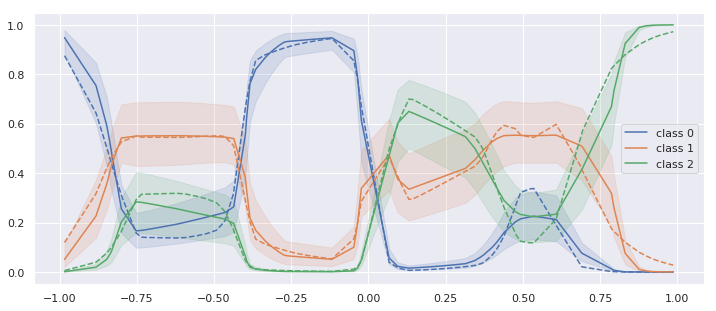

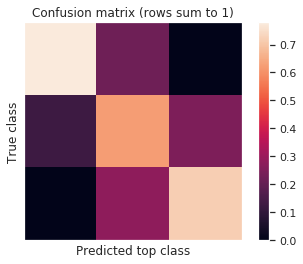

In [6]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 50       
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
pred_class = np.argmax(y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
pred_class_onehot = onehot(pred_class)
pred_class_mean = pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N):
    conf_matrix[t_values[i]] += pred_class_mean[i]
conf_matrix /= conf_matrix.sum(1, keepdims=True)




##### ML MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 50       
with torch.no_grad():
    # Compute deterministic NN output
    h = ml_features(x)
    ml_y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = ml_mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        ml_y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

ml_y_all = np.concatenate(ml_y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
ml_pred_class = np.argmax(ml_y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
ml_pred_class_onehot = onehot(ml_pred_class)
ml_pred_class_mean = ml_pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
ml_conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N):
    ml_conf_matrix[t_values[i]] += ml_pred_class_mean[i]
ml_conf_matrix /= ml_conf_matrix.sum(1, keepdims=True)





###### PLOT STUFF

### Plot class probability outputs of the classifier (distribution over different samples of a,b)
y_lower = np.percentile(y_all, 5, axis=0)
y_upper = np.percentile(y_all, 95, axis=0)
y_mean = np.mean(y_all, axis=0)
ml_y_mean = np.mean(ml_y_all, axis=0)
x_numpy = x.detach().cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
for c in range(n_classes):
    plot(x_numpy, y_mean[:, c], y_lower[:, c], y_upper[:, c], color=sns.color_palette()[c],
         alpha=0.15, title='90% interval of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='$Pr(c | x, a, b)$', 
         label='class {}'.format(c))
    plot(x_numpy, ml_y_mean[:, c], color=sns.color_palette()[c], linestyle='--')
plt.show()


# ### Plot probability of selecting each class (argmax version of the previous plot) - maybe this is useless
# plt.figure(figsize=(12, 7))
# for c in range(n_classes):
#     plot(x_numpy, pred_class_mean[:, c], color=sns.color_palette()[c], title='prob of classification of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='', 
#          label='class {}'.format(c))
# plt.show()


### Show confusion matrix
plt.imshow(conf_matrix)
plt.colorbar()
plt.grid(False)
clean_curr_axes()
plt.title('Confusion matrix (rows sum to 1)')
plt.xlabel('Predicted top class')
plt.ylabel('True class')
plt.show()


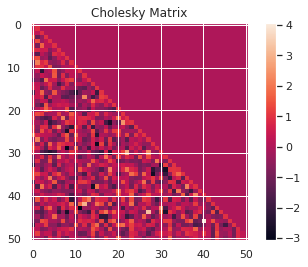

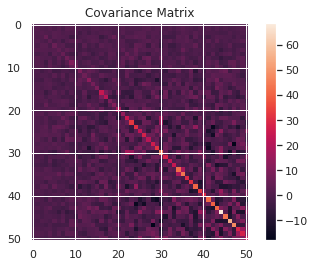

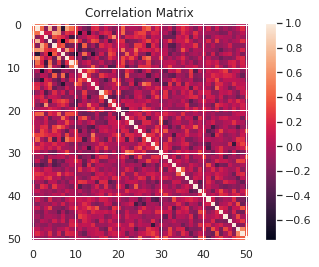

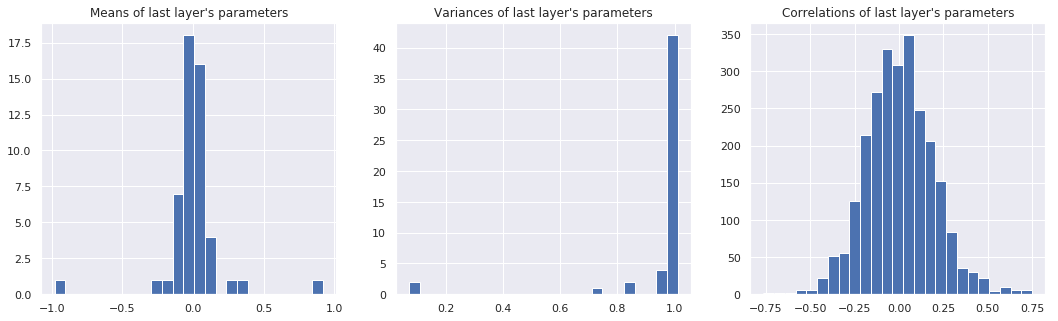

In [7]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix")
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix")
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(logvar_ab.exp().detach(), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()